In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom, beta
import pandas as pd
import preliz as pz
import pymc as pm

### Exercise 4 : import arviz as az
Read about the coal mining disaster model that is part of the PyMC documentation
  Try to implement and run this model by yourself.

NOTE url in book is wrong. Correct url is: 
https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#case-study-2-coal-mining-disasters

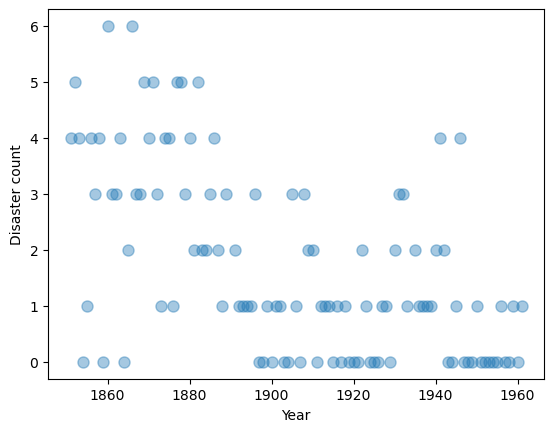

In [4]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

Idea here is that we expect to see an improvement in coal mining disasters after the implementation of new safety regulations.  We don't known the date of the change, so we will use switchpoint analysis:

$$
\begin{align}
D_t &\sim \text{Poisson}(r_t) \text{ ,} r_t = 
\begin{cases}
  e & \text{if } t < s \\
  l & \text{if } t \ge s
\end{cases}\\

s &\sim \text{Unif}(t_l, t_h)\\
e &\sim \text{exp}(1)\\
l &\sim \text{exp}(1)

\end{align}
$$

$D_t$ is the number of disasters in year $t$.  $s$ is the switchpoint, the year in which the rate changes.  $e$ and $l$ are the early and late rates, respectively.   

In [6]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/Users/ronaldlegere/miniconda3/envs/bap3/lib/python3.11/site-packages/pymc/model/core.py:1342: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/Users/ronaldlegere/miniconda3/envs/bap3/lib/python3.11/site-packages/pymc/model/core.py:1365: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Note warnings about imputations. 

In [7]:
with disaster_model:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
>>Metropolis: [disasters_unobserved]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 4 seconds.


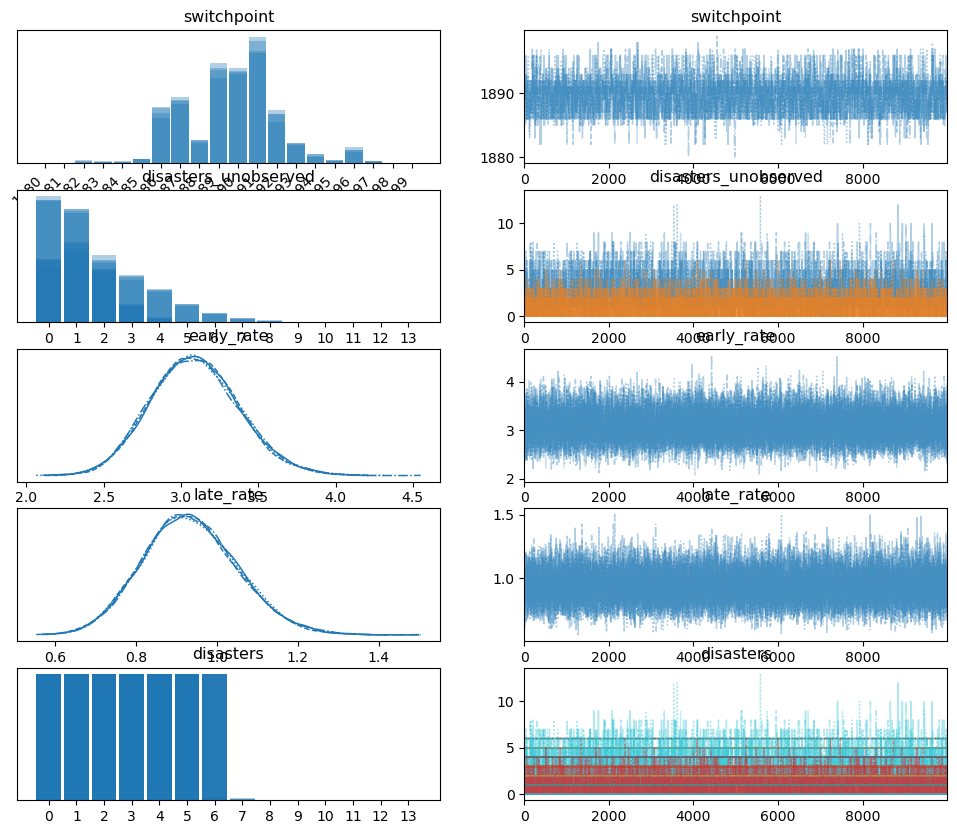

In [8]:
axes_arr = az.plot_trace(idata)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

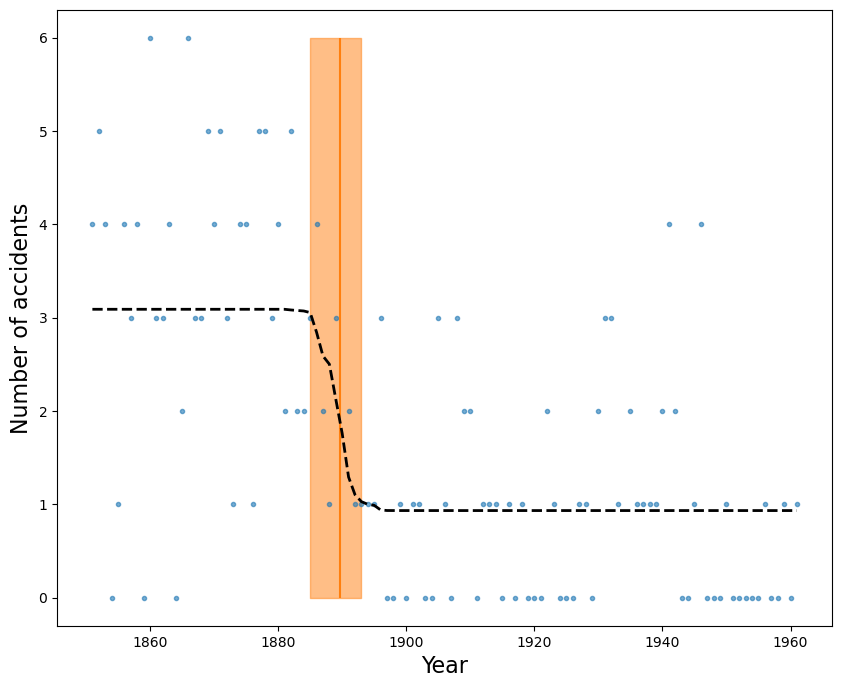

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);